In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from IPython.display import display
import qtpu
import optuna
from qtpu.compiler import hyper_optimize
from qtpu.compiler.compiler import find_best_trial, trial_to_hybrid_tn
from qtpu.compiler.terminators import reach_num_qubits


In [4]:
from benchmark.benchmarks import generate_benchmark
from benchmark.benchmarks import random_ansatz, linear_ansatz, brick_ansatz, cluster_ansatz


tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 10,
    # line width
    "lines.linewidth": 2,
    # set markersize
    "lines.markersize": 8,
    "lines.markeredgewidth": 1.5,
    "lines.markeredgecolor": "black",
}

plt.rcParams.update(tex_fonts)


def plot_pareto_front(study: optuna.Study, ax: plt.Axes) -> None:
    trials = set(tuple(trial.values) for trial in study.trials)
    best_trials = sorted(
        set(tuple(trial.values) for trial in study.best_trials),
        key=lambda x: (x[0], -x[1]),
    )
    non_optimal_trials = trials - set(best_trials)

    
    ax.plot(
        [vals[0] for vals in non_optimal_trials],
        [vals[1] for vals in non_optimal_trials],
        "x",
        label="Non-optimal",
    )
    ax.plot(
        [vals[0] for vals in best_trials],
        [vals[1] for vals in best_trials],
        "o--",
        label="Pareto optimal",
        color="red",
    )

    ax.set_xlabel("Contraction Cost")
    ax.set_ylabel("Success")

In [8]:
# names = ["qaoa_3"]
# benches = [generate_benchmark(name, 50) for name in names]
benches = [random_circuit(30, 10, max_operands=2)]

studies = [
    hyper_optimize(circuit, max_cost=10000, show_progress_bar=True)
    for circuit in benches
]


  0%|          | 0/100 [00:00<?, ?it/s]

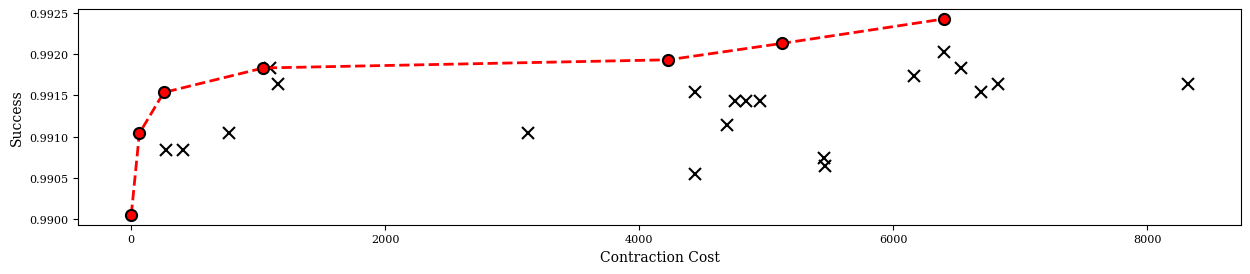

In [9]:
WIDE_FIGSIZE = (15, 2.8)
fig, axes = plt.subplots(1, len(benches), figsize=WIDE_FIGSIZE)

if len(benches) == 1:
    axes = [axes]
for ax, study in zip(axes, studies):
    plot_pareto_front(study, ax)
    # ax.set_xlim(0, 1e10)
fig;

In [ ]:
fig.savefig("pareto.pdf", bbox_inches="tight")

In [10]:
study = studies[0]
trial = find_best_trial(study)
htn = trial_to_hybrid_tn(trial)
trial

FrozenTrial(number=37, state=1, values=[1040.0, 0.9918331216146344], datetime_start=datetime.datetime(2024, 6, 16, 9, 27, 10, 896012), datetime_complete=datetime.datetime(2024, 6, 16, 9, 27, 10, 920698), params={'compress': 'none', 'choose_leaf': 'nodes', 'random_strength': 9.399541122663184, 'weight_edges': 'const', 'imbalance': 0.48318765004984066, 'imbalance_decay': 3.743028348061687, 'parts': 4, 'parts_decay': 0.00024303261101510376, 'mode': 'direct', 'objective': 'cut', 'fix_output_nodes': 'auto'}, user_attrs={'ir': <qtpu.compiler.compress.CompressedIR object at 0x7fdd6d580490>, 'tree': <ContractionTree(N=100, branches=2, complete=False)>}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'compress': CategoricalDistribution(choices=('qubits', '2q', 'none')), 'choose_leaf': CategoricalDistribution(choices=('qubits', 'nodes', 'random')), 'random_strength': FloatDistribution(high=10.0, log=False, low=0.01, step=None), 'weight_edges': CategoricalDistributio

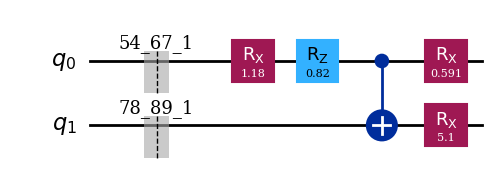

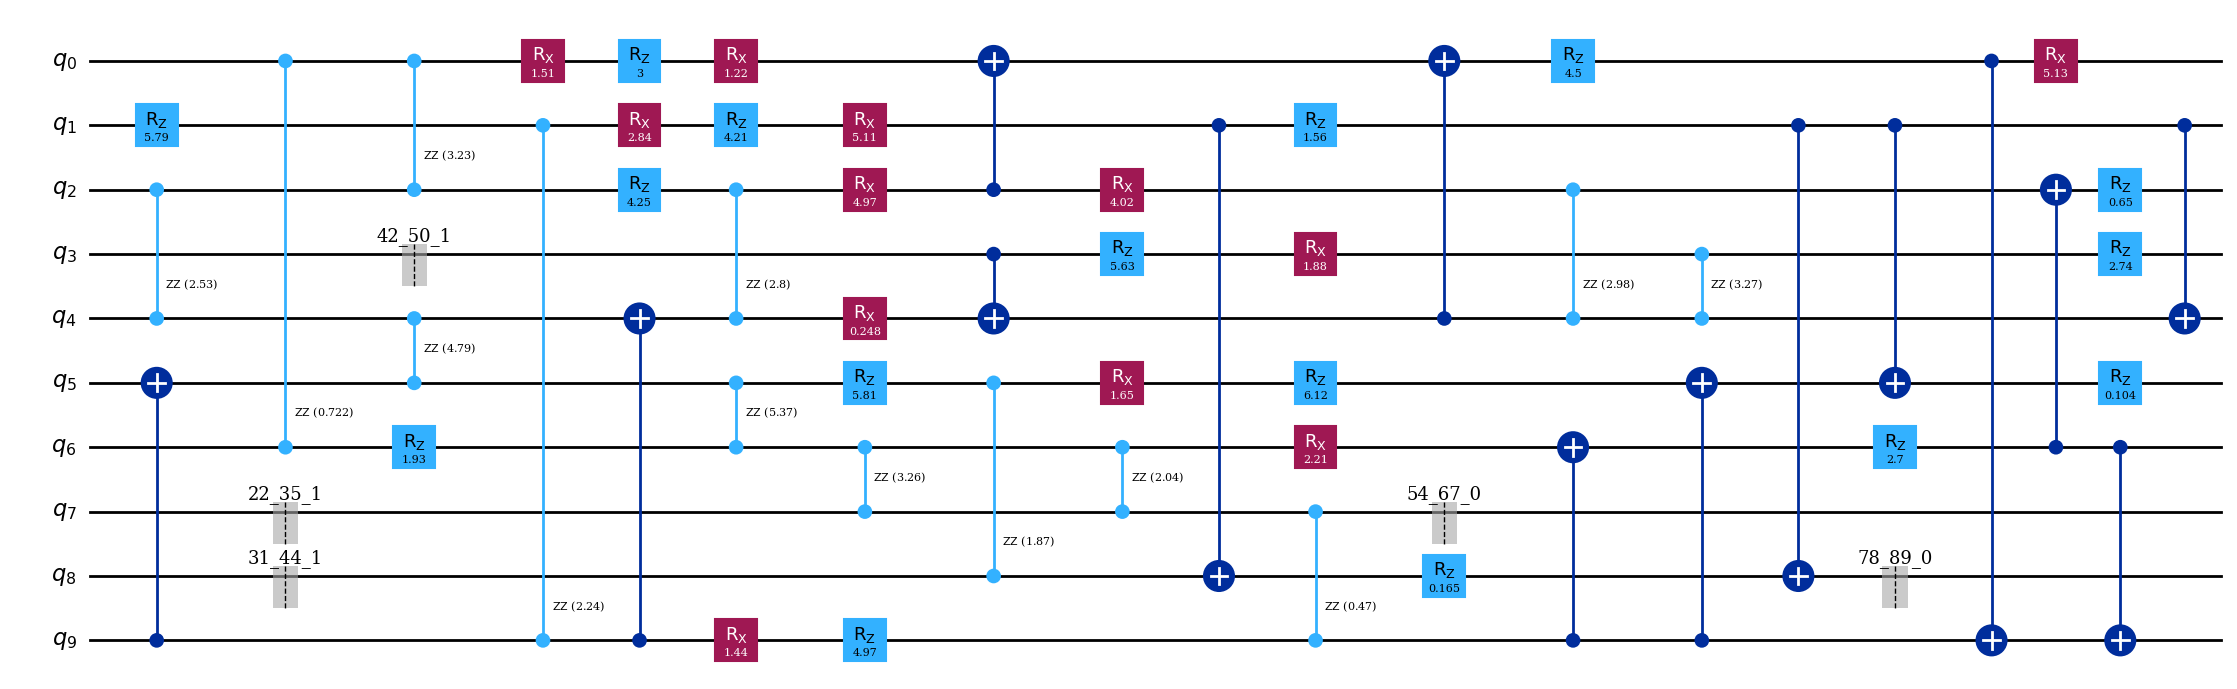

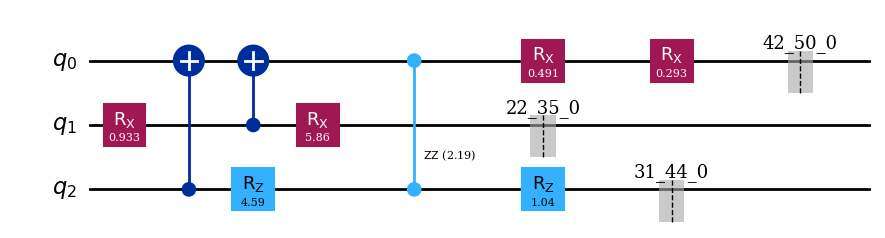

In [11]:
for qtens in htn.quantum_tensors:
    display(qtens.circuit.draw(output="mpl", fold=-1))

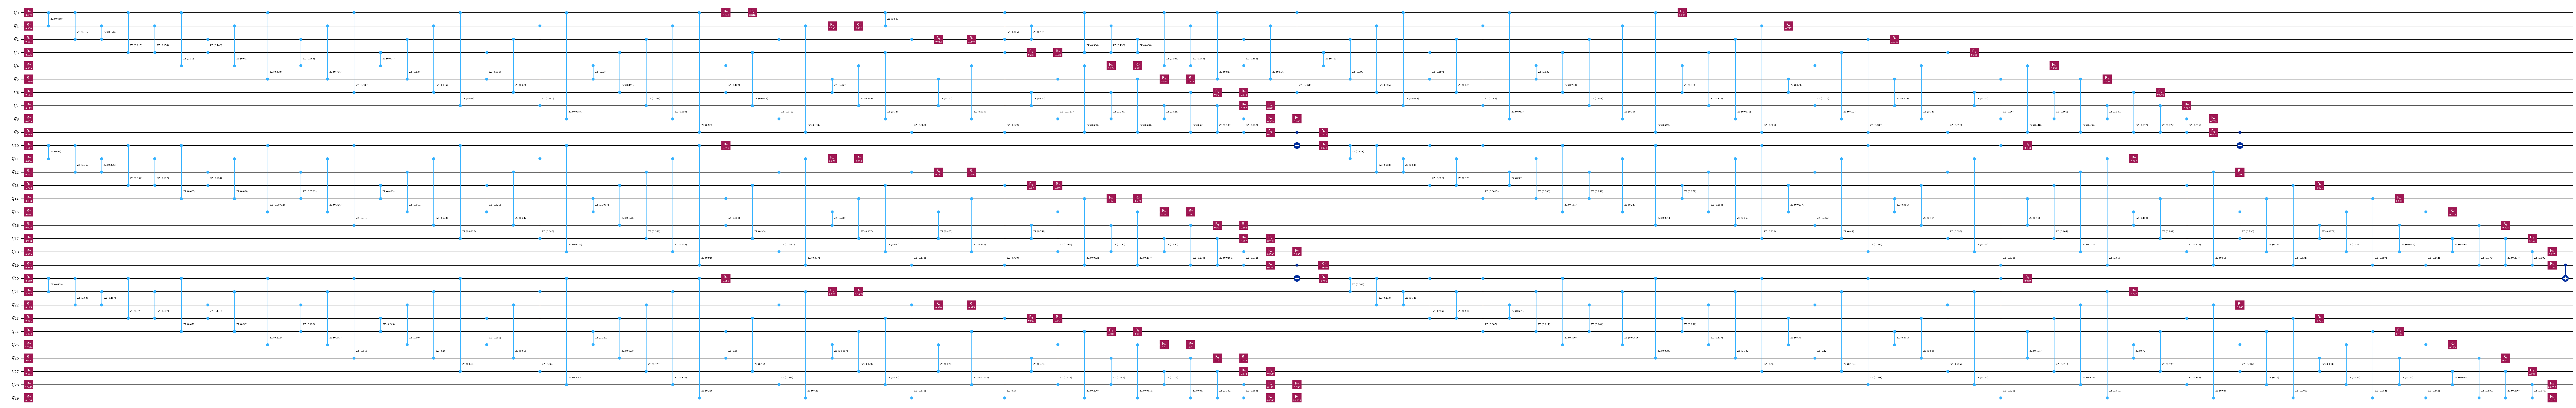

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import TwoLocal


def get_cluster(num_qubits: int):
    cluster = TwoLocal(num_qubits, "ry", "rzz", reps=1)
    cluster = cluster.assign_parameters(np.random.rand(cluster.num_parameters))
    return cluster
    

def clustered_circuit(cluster_sizes: list[int], num_layers: int):
    circuit = QuantumCircuit(sum(cluster_sizes))
    for _ in range(num_layers):
        start = 0
        for s in cluster_sizes:
            cluster = get_cluster(s)
            circuit.compose(cluster, range(start, start + s), inplace=True)
            start += s
        start = 0
        for s in cluster_sizes[:-1]:

            circuit.cx(start + s - 1, start + s)
            start += s
    return circuit.decompose()
                
    
clustered_circuit([10, 10, 10], 2).draw("mpl", fold=-1)


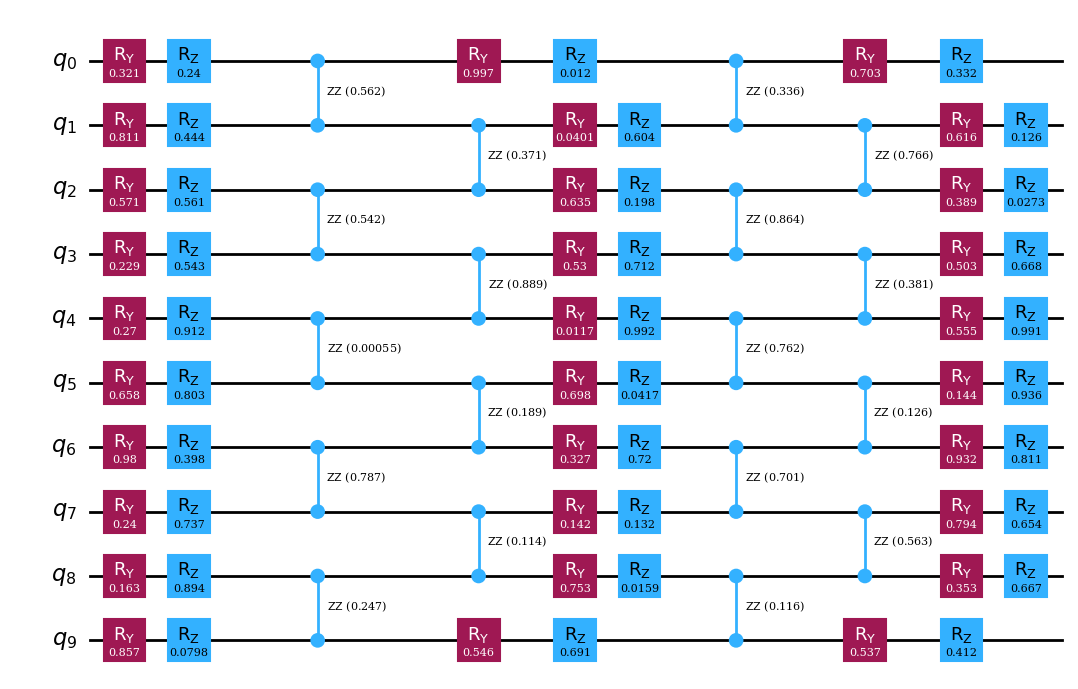

In [ ]:
def brickwork_circuit(num_qubits: int, num_layers: int):
    circuit = TwoLocal(
        num_qubits, ["ry", "rz"], "rzz", entanglement="pairwise", reps=num_layers
    )
    circuit = circuit.assign_parameters(np.random.rand(circuit.num_parameters))
    return circuit.decompose()


b = brickwork_circuit(10, 2)
from qiskit_aer import AerSimulator

# b = transpile(b, backend=AerSimulator(), optimization_level=3, approximation_degree=1.0)

b.draw("mpl", fold=-1)

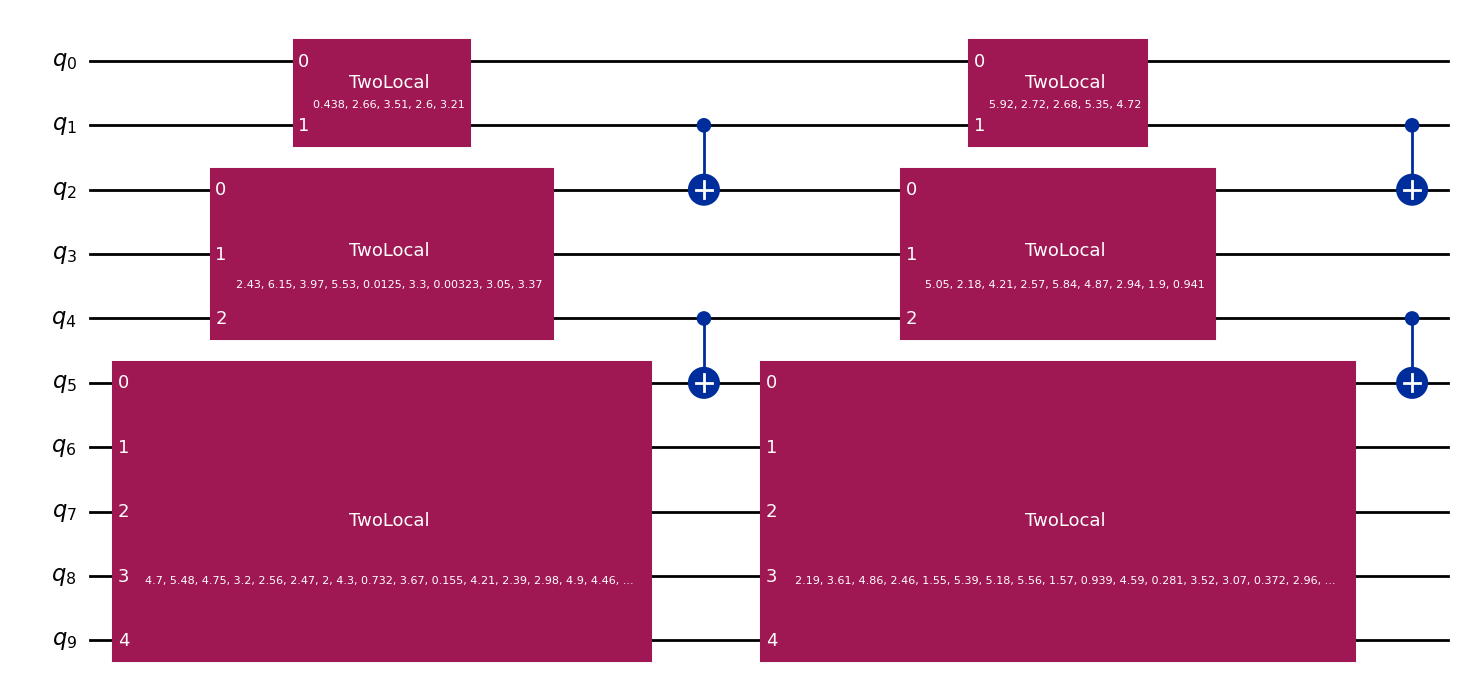

In [ ]:

a = cluster_ansatz([2, 3, 5], 2)
a.draw("mpl", fold=-1)

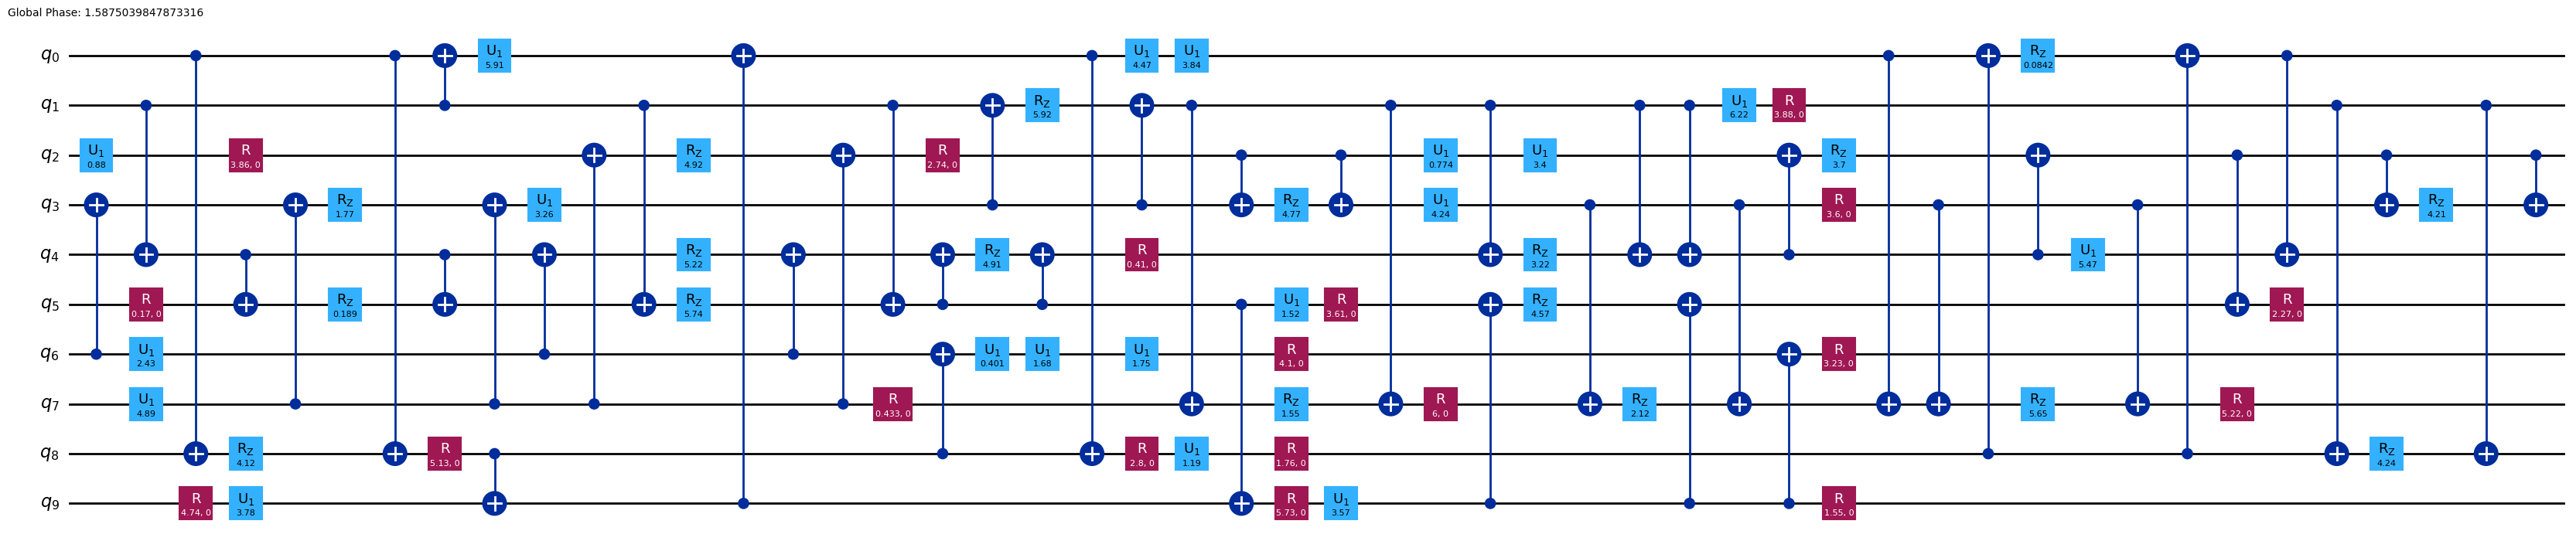

In [ ]:
from qiskit.circuit.random import random_circuit

random_circuit(10, 10, max_operands=2).decompose().draw("mpl", fold=-1)